# Traffic Counts: simple, step‑by‑step cleaning walkthrough
This notebook guides you through a clear, minimal data‑cleaning flow for `data/dataset/traffic_counts.csv` and saves a cleaned JSON array ready for downstream use.

We will:
1) Install/import libraries
2) Load the CSV
3) Inspect nulls and schema
4) Visualize key columns
5) Clean step‑by‑step (timestamps, drop all‑null columns, optional column removals, simple NA handling)
6) Save cleaned JSON and preview

In [2]:
# 1) Install and import libraries
import sys, subprocess, importlib, warnings
from datetime import timezone
from pathlib import Path

warnings.filterwarnings('ignore')

def ensure(pkg):
    try:
        return importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
        return importlib.import_module(pkg)

pd = ensure('pandas')
np = ensure('numpy')
sns = ensure('seaborn')
mpl = ensure('matplotlib')
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')
print('Versions:',
      'pandas', pd.__version__,
      'numpy', np.__version__,
      'seaborn', sns.__version__)

Versions: pandas 2.3.3 numpy 2.3.4 seaborn 0.13.2


In [4]:
# 2) Load CSV
from pathlib import Path
import pandas as pd

# Robust project root detection (works if CWD is notebook folder or repo root)
CWD = Path.cwd().resolve()
for base in [CWD, CWD.parent, CWD.parent.parent]:
    candidate = base / 'data' / 'dataset' / 'traffic_counts.csv'
    if candidate.exists():
        ROOT = base
        break
else:
    raise FileNotFoundError(f"Could not find data/dataset/traffic_counts.csv starting from {CWD}")

csv_path = ROOT / 'data' / 'dataset' / 'traffic_counts.csv'
print('Using ROOT =', ROOT)
print('CSV path =', csv_path)

df = pd.read_csv(csv_path, encoding='utf-8-sig')
print('Shape:', df.shape)
display(df.head(5))

Using ROOT = C:\Users\ASUS\Documents\real-time-iot-traffic-analytics
CSV path = C:\Users\ASUS\Documents\real-time-iot-traffic-analytics\data\dataset\traffic_counts.csv
Shape: (5236, 15)


,detector_id,detector_type,detector_status,detector_direction,detector_movement,location_name,atd_location_id,signal_id,created_date,modified_date,ip_comm_status,comm_status_datetime_utc,location_latitude,location_longitude,LOCATION
0,"2,060",LOOP,OK,WESTBOUND,THRU / RIGHT TURN,FM 620 RD / BOULDER LN (South),LOC16-004375,888.0,2017 Jun 26 12:00:00 AM,2025 Apr 15 06:52:00 PM,NaN,NaN,NaN,NaN,POINT (-97.842659 30.428783)
1,"1,730",LOOP,OK,NORTHBOUND,THRU / RIGHT TURN,5TH ST / PRESSLER ST,LOC16-004680,958.0,2017 Jun 28 12:00:00 AM,2025 Feb 13 10:30:00 PM,NaN,NaN,NaN,NaN,POINT (-97.760832 30.272729)
2,"1,076",LOOP,BROKEN,WESTBOUND,THRU / RIGHT TURN,WILLIAM CANNON DR / BRUSH COUNTRY RD,LOC16-002130,434.0,NaN,2025 Oct 27 07:12:00 PM,NaN,NaN,NaN,NaN,POINT (-97.841698 30.223387)
3,"1,566",LOOP,REMOVED,EASTBOUND,LEFT TURN,US 290 HWY SVRD / PARMER LN,LOC16-004855,993.0,2017 Jun 28 12:00:00 AM,2022 Dec 29 12:26:00 PM,NaN,NaN,NaN,NaN,POINT (-97.581018 30.344859)
4,"2,029",LOOP,OK,SOUTHBOUND,LEFT TURN,BRODIE LN / 290 HWY SVRD,LOC16-004395,892.0,2017 Jun 26 12:00:00 AM,2023 Dec 17 05:30:00 PM,NaN,NaN,NaN,NaN,POINT (-97.818329 30.233582)


In [ ]:
# 3) Inspect nulls and schema
from io import StringIO
buf = StringIO()
df.info(buf=buf)
print(buf.getvalue())
null_counts = df.isna().sum().sort_values(ascending=False)
null_percent = (null_counts / len(df) * 100).round(2)
summary = pd.DataFrame({'nulls': null_counts, 'null_%': null_percent})
display(summary.head(20))
all_null_cols = [c for c in df.columns if df[c].isna().all()]
print('Columns with all nulls:', all_null_cols)
dupes = df.duplicated().sum()
print('Duplicate rows (across all columns):', dupes)
display(df.describe(include='all').transpose().head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5236 entries, 0 to 5235
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   detector_id               5236 non-null   object 
 1   detector_type             5236 non-null   object 
 2   detector_status           5235 non-null   object 
 3   detector_direction        5212 non-null   object 
 4   detector_movement         5211 non-null   object 
 5   location_name             5220 non-null   object 
 6   atd_location_id           5220 non-null   object 
 7   signal_id                 5220 non-null   float64
 8   created_date              4700 non-null   object 
 9   modified_date             5236 non-null   object 
 10  ip_comm_status            0 non-null      float64
 11  comm_status_datetime_utc  0 non-null      float64
 12  location_latitude         0 non-null      float64
 13  location_longitude        0 non-null      float64
 14  LOCATION

,nulls,null_%
location_latitude,5236,100.00
location_longitude,5236,100.00
ip_comm_status,5236,100.00
comm_status_datetime_utc,5236,100.00
created_date,536,10.24
detector_movement,25,0.48
detector_direction,24,0.46
location_name,16,0.31
signal_id,16,0.31
LOCATION,16,0.31


Columns with all nulls: ['ip_comm_status', 'comm_status_datetime_utc', 'location_latitude', 'location_longitude']
Duplicate rows (across all columns): 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
detector_id,5236,5236,"2,060",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detector_type,5236,10,LOOP,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detector_status,5235,8,OK,3109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detector_direction,5212,9,EASTBOUND,1320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detector_movement,5211,67,LEFT TURN,1036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_name,5220,881,CAPITAL OF TEXAS HWY / MOPAC EXPY SVRD,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
atd_location_id,5220,955,LOC16-000720,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
signal_id,5220.0,NaN,NaN,NaN,605.126054,401.825097,2.0,361.75,613.0,844.0,4143.0
created_date,4700,625,2017 Sep 11 12:00:00 AM,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modified_date,5236,2708,2019 Apr 09 07:47:00 PM,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Numeric columns: ['signal_id', 'ip_comm_status', 'comm_status_datetime_utc', 'location_latitude', 'location_longitude']


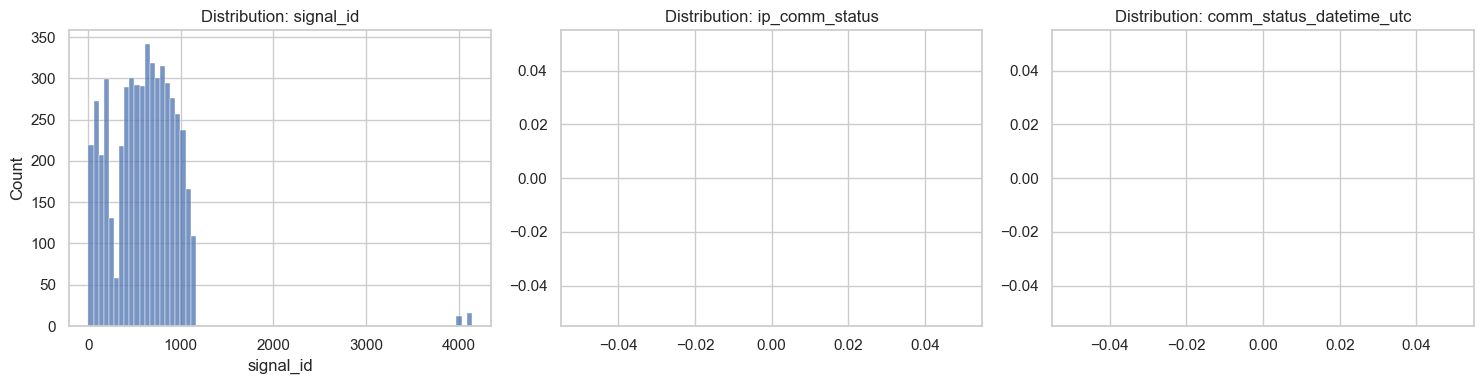

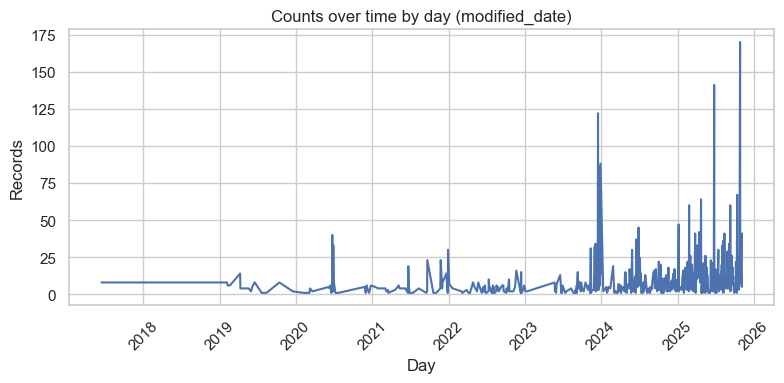

In [6]:
# 4) Visualize key columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols[:8])
# Plot up to 3 histograms
n_plot = min(3, len(numeric_cols))
if n_plot > 0:
    fig, axes = plt.subplots(1, n_plot, figsize=(5*n_plot, 4))
    if n_plot == 1: axes = [axes]
    for ax, col in zip(axes, numeric_cols[:n_plot]):
        sns.histplot(df[col].dropna(), kde=False, ax=ax)
        ax.set_title(f'Distribution: {col}')
    plt.tight_layout()
else:
    print('No numeric columns found to plot.')

# Optional: time series if a timestamp-like column exists
ts_col = None
for candidate in ['modified_date','created_date','timestamp','time','date','datetime']:
    if candidate in df.columns:
        ts_col = candidate; break
if ts_col:
    dt = pd.to_datetime(df[ts_col], errors='coerce', utc=True)
    by_day = dt.dt.floor('D').value_counts().sort_index()
    if not by_day.empty:
        plt.figure(figsize=(8,4))
        sns.lineplot(x=by_day.index, y=by_day.values)
        plt.title(f'Counts over time by day ({ts_col})')
        plt.xlabel('Day')
        plt.ylabel('Records')
        plt.xticks(rotation=45)
        plt.tight_layout()
else:
    print('No obvious timestamp column found for time series.')

In [7]:
# 5) Clean step-by-step
def to_iso8601_utc(s):
    if pd.isna(s):
        return None
    try:
        dt = pd.to_datetime(s, errors='coerce', utc=True)
        if pd.isna(dt):
            return None
        return dt.isoformat().replace('+00:00','Z')
    except Exception:
        return None

clean = df.copy()

# 5a) Normalize timestamps if present
for c in ['created_date','modified_date','timestamp','time','date','datetime']:
    if c in clean.columns:
        clean[c] = clean[c].apply(to_iso8601_utc)

# 5b) Drop columns that are entirely null
all_null_cols = [c for c in clean.columns if clean[c].isna().all()]
if all_null_cols:
    clean = clean.drop(columns=all_null_cols)
    print('Dropped all-null columns:', all_null_cols)

# 5c) Optional column removals (match earlier requirements)
drop_latitude = True
drop_created_ts = True
if drop_latitude:
    for c in ['latitude','lat','location_latitude']:
        if c in clean.columns:
            clean = clean.drop(columns=[c])
            print('Dropped column:', c)
if drop_created_ts:
    for c in ['created_date']:
        if c in clean.columns:
            clean = clean.drop(columns=[c])
            print('Dropped column:', c)

# 5d) Simple NA handling: fill numeric NaNs with 0, leave others as-is
num_cols = clean.select_dtypes(include=[np.number]).columns
if len(num_cols):
    clean[num_cols] = clean[num_cols].fillna(0)

print('Clean shape:', clean.shape)
display(clean.head(5))

Dropped all-null columns: ['ip_comm_status', 'comm_status_datetime_utc', 'location_latitude', 'location_longitude']
Dropped column: created_date
Clean shape: (5236, 10)


,detector_id,detector_type,detector_status,detector_direction,detector_movement,location_name,atd_location_id,signal_id,modified_date,LOCATION
0,"2,060",LOOP,OK,WESTBOUND,THRU / RIGHT TURN,FM 620 RD / BOULDER LN (South),LOC16-004375,888.0,2025-04-15T18:52:00Z,POINT (-97.842659 30.428783)
1,"1,730",LOOP,OK,NORTHBOUND,THRU / RIGHT TURN,5TH ST / PRESSLER ST,LOC16-004680,958.0,2025-02-13T22:30:00Z,POINT (-97.760832 30.272729)
2,"1,076",LOOP,BROKEN,WESTBOUND,THRU / RIGHT TURN,WILLIAM CANNON DR / BRUSH COUNTRY RD,LOC16-002130,434.0,2025-10-27T19:12:00Z,POINT (-97.841698 30.223387)
3,"1,566",LOOP,REMOVED,EASTBOUND,LEFT TURN,US 290 HWY SVRD / PARMER LN,LOC16-004855,993.0,2022-12-29T12:26:00Z,POINT (-97.581018 30.344859)
4,"2,029",LOOP,OK,SOUTHBOUND,LEFT TURN,BRODIE LN / 290 HWY SVRD,LOC16-004395,892.0,2023-12-17T17:30:00Z,POINT (-97.818329 30.233582)


In [8]:
# 6) Save cleaned JSON array
out_json = ROOT / 'data' / 'dataset' / 'traffic_counts_kafka.json'
def prune_nones(obj):
    if isinstance(obj, dict):
        return {k: prune_nones(v) for k,v in obj.items() if v is not None and not (isinstance(v, float) and np.isnan(v))}
    elif isinstance(obj, list):
        return [prune_nones(x) for x in obj]
    else:
        return obj
records = clean.to_dict(orient='records')
records = [prune_nones(r) for r in records]
import json
with open(out_json, 'w', encoding='utf-8') as f:
    json.dump(records, f, ensure_ascii=False)
print('Wrote JSON:', out_json)
print('Record count:', len(records))

Wrote JSON: C:\Users\ASUS\Documents\real-time-iot-traffic-analytics\data\dataset\traffic_counts_kafka.json
Record count: 5236


In [9]:
# 7) Quick validation preview of saved output
from itertools import islice
with open(out_json, 'r', encoding='utf-8') as f:
    data = json.load(f)
print('Total records:', len(data))
print('First record:')
print(json.dumps(next(iter(data), {}), indent=2)[:2000])

Total records: 5236
First record:
{
  "detector_id": "2,060",
  "detector_type": "LOOP",
  "detector_status": "OK",
  "detector_direction": "WESTBOUND",
  "detector_movement": "THRU / RIGHT TURN",
  "location_name": "FM 620 RD / BOULDER LN (South)",
  "atd_location_id": "LOC16-004375",
  "signal_id": 888.0,
  "modified_date": "2025-04-15T18:52:00Z",
  "LOCATION": "POINT (-97.842659 30.428783)"
}
